# Air Quality Forecasting using LSTM for PM2.5 prediction

## Problem Statement

Air pollution, especially fine particulate matter like PM2.5, poses serious health risks and environmental challenges. Accurate forecasting of PM2.5 levels can help authorities and individuals take proactive measures. This project aims to predict future PM2.5 concentrations using time series modeling techniques on historical air quality data from Beijing.


## Objective, here belwo is my objective.

- To predict future **PM2.5** concentrations based on past measurements.
- To use advanced deep learning models, specifically **RNNs and LSTMs** to capture temporal dependencies.
- To **Minimize RMSE** on the test set to below the threshold of **4000** as required.


## Strategy & Workflow

This project will follow a structured approach, including:

### 1. **Data Exploration**
- Explore time-based patterns and identifying trends or seasonality in PM2.5 values.
- Visualizing correlations and missing data.
  
### 2. **Preprocessing & Feature Engineering**
- Handling missing values with interpolation or forward/backward filling.
- Scali ofng features using `MinMaxScaler`.
- Generating input sequences using a time window approach (e.g., past 24 or 48 hours to predict the next hour).
  
### 3. **Modeling with RNNs/LSTMs**
- I will Start with a baseline LSTM model and improve iteratively.
- I will experiment with architectures (layers, units), hyperparameters (learning rate, batch size) and regularization.
- I will justify the use of LSTM due to its ability to model long-term dependencies and mitigate vanishing gradient problems.

### 4. **Evaluation & Experimentation**
- I will run different parameters and documenting results (RMSE).
- I will visualize predicted vs. actual values.


## Why Use RNNs & LSTMs?

- **RNNs** are designed for sequential data but suffer from vanishing/exploding gradient problems over long sequences.
- **LSTMs (Long Short-Term Memory networks)** overcome this by using memory cells and gates making them ideal for capturing long-term dependencies in air quality time series data.



In [26]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop
import math
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import os

In [27]:
# Mount Google Drive to access datasets
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
# Loading the training and testing datasets from my Google Drive
train = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/test.csv')



## Data Exploration

 I am going to explore the training dataset to understand its structure, variable types and any data quality issues such as missing values. And also to very well understand the dataset dimensions and types. I will summarize key statistics, visualize feature distributions & as well as identifying missing values especially in the target variable **pm2.5**


Dataset shape: (30676, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30676 entries, 0 to 30675
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   No        30676 non-null  int64  
 1   DEWP      30676 non-null  float64
 2   TEMP      30676 non-null  float64
 3   PRES      30676 non-null  float64
 4   Iws       30676 non-null  float64
 5   Is        30676 non-null  float64
 6   Ir        30676 non-null  float64
 7   datetime  30676 non-null  object 
 8   cbwd_NW   30676 non-null  float64
 9   cbwd_SE   30676 non-null  float64
 10  cbwd_cv   30676 non-null  float64
 11  pm2.5     28755 non-null  float64
dtypes: float64(10), int64(1), object(1)
memory usage: 2.8+ MB


,count,mean,std,min,25%,50%,75%,max
No,30676.0,15338.500000,8855.542765,1.000000,7669.750000,15338.500000,23007.250000,30676.000000
DEWP,30676.0,-0.029431,0.994087,-2.135153,-0.888034,-0.056622,0.913358,1.814055
TEMP,30676.0,-0.062712,1.015193,-2.578070,-0.938521,0.045209,0.864984,2.340578
PRES,30676.0,0.013612,1.008991,-2.380821,-0.822670,-0.043595,0.832865,2.877939
Iws,30676.0,0.030542,1.018337,-0.468688,-0.441894,-0.352512,0.005216,11.231956
Is,30676.0,0.016992,1.087278,-0.069353,-0.069353,-0.069353,-0.069353,35.439859
Ir,30676.0,0.011253,1.063811,-0.137667,-0.137667,-0.137667,-0.137667,25.288745
cbwd_NW,30676.0,0.016193,1.006001,-0.690542,-0.690542,-0.690542,1.448138,1.448138
cbwd_SE,30676.0,0.005833,1.001847,-0.732019,-0.732019,-0.732019,1.366085,1.366085
cbwd_cv,30676.0,-0.025008,0.982122,-0.522096,-0.522096,-0.522096,-0.522096,1.915355



Missing values per column:
No             0
DEWP           0
TEMP           0
PRES           0
Iws            0
Is             0
Ir             0
datetime       0
cbwd_NW        0
cbwd_SE        0
cbwd_cv        0
pm2.5       1921
dtype: int64


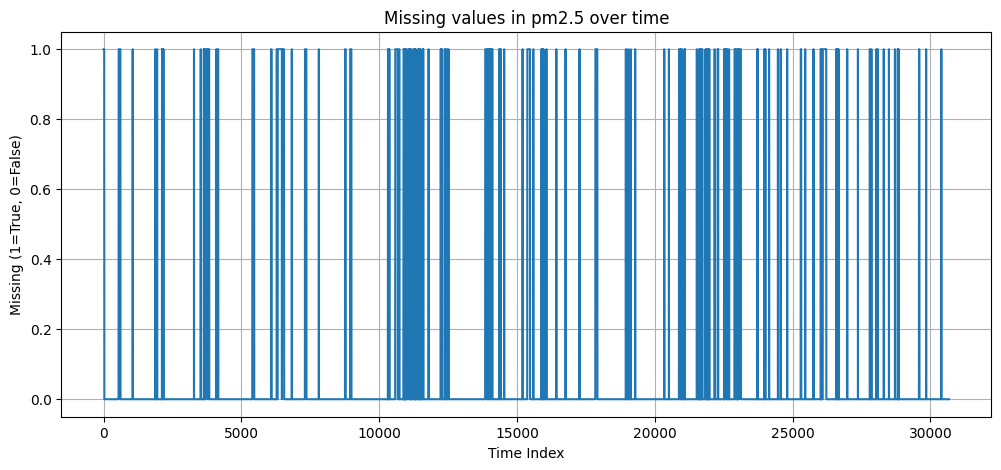


 Missing target values (pm2.5): 1921 (6.26% of the dataset)


In [29]:
# Displaying shape and first few rows
print("Dataset shape:", train.shape)
train.head()

# Checking data types and non-null counts
train.info()

# Statistics summary
display(train.describe().T)

# Checking for missing values
missing_values = train.isnull().sum()
print("\nMissing values per column:")
print(missing_values)

# Visualizing missing values in pm2.5
plt.figure(figsize=(12, 5))
train['pm2.5'].isnull().astype(int).plot(kind='line', title="Missing values in pm2.5 over time")
plt.xlabel("Time Index")
plt.ylabel("Missing (1=True, 0=False)")
plt.grid(True)
plt.show()

# Counting percentage of missing in target
pm_missing_pct = (missing_values['pm2.5'] / len(train)) * 100
print(f"\n Missing target values (pm2.5): {missing_values['pm2.5']} ({pm_missing_pct:.2f}% of the dataset)")


**VISUAL EXPLORATION**

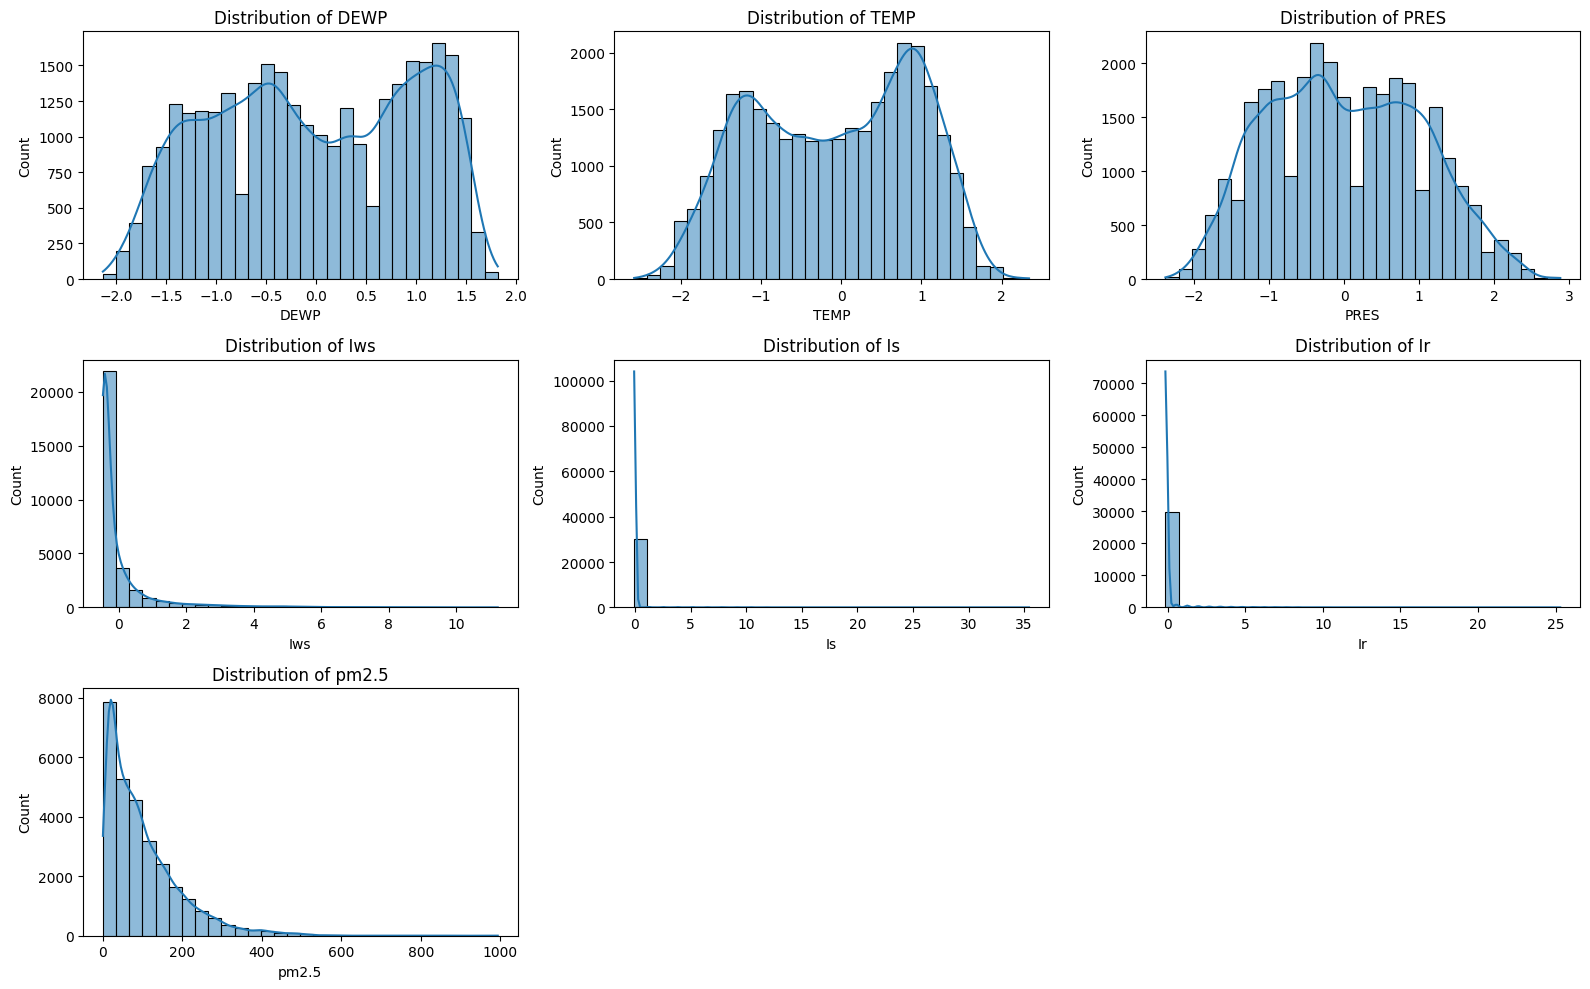

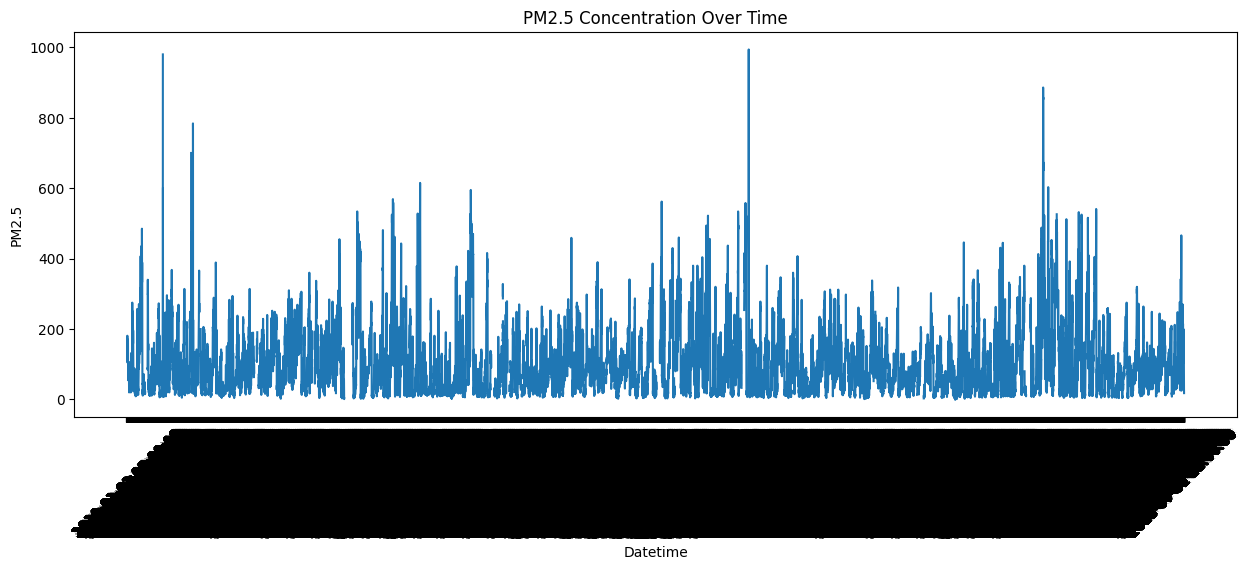

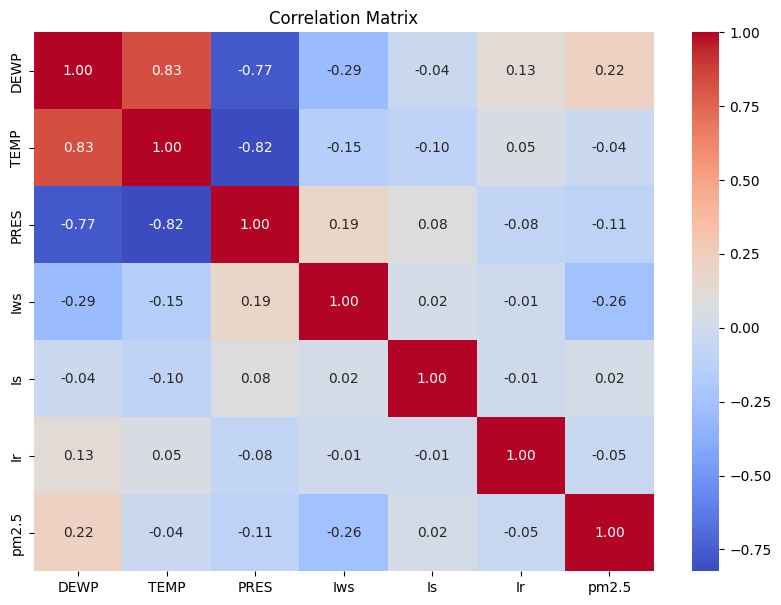

In [30]:
# Plotting distributions of key features including the target pm2.5
features = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'pm2.5']
plt.figure(figsize=(16, 10))
for i, feature in enumerate(features):
    plt.subplot(3, 3, i+1)
    sns.histplot(train[feature].dropna(), kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

# Time series plot of pm2.5 over the whole period
plt.figure(figsize=(15,5))
plt.plot(train['datetime'], train['pm2.5'])
plt.title("PM2.5 Concentration Over Time")
plt.xlabel("Datetime")
plt.ylabel("PM2.5")
plt.xticks(rotation=45)
plt.show()

# Correlation heatmap for features and pm2.5
plt.figure(figsize=(10, 7))
corr = train[features].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


# Data Preprocessing

I dropped unneeded columns, converted `datetime`, dropped missing target rows, scaled features and target and created sequences.


In [32]:
train = train.drop(columns='No')
test = test.drop(columns='No')

train['datetime'] = pd.to_datetime(train['datetime'])
test['datetime'] = pd.to_datetime(test['datetime'])

train = train.dropna()

In [34]:
feature_cols = ['DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir']
target_col = 'pm2.5'

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train[feature_cols])
target_scaled = scaler.fit_transform(train[[target_col]])

# Converting to sequences
def create_sequences(data, labels, time_steps=24):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(labels[i+time_steps])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, target_scaled)


# Building the LSTM Model

Defining the model architecture, compiling it and displaying the summary.


In [35]:
optimizer = Adam(learning_rate=0.001)

model = Sequential([
    LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001), input_shape=(X_train.shape[1], X_train.shape[2])),
    BatchNormalization(),
    Dropout(0.3),

    LSTM(32, kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(1)
])

model.compile(optimizer=optimizer, loss='mse', metrics=[RootMeanSquaredError()])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 24, 64)         │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,009 (121.13 KB)

 Trainable params: 30,817 (120.38 KB)

 Non-trainable params: 192 (768.00 B)

# Splitting data and training the Model

Splitting data into training and validation sets, trainning the model with callbacks and monitoring loss and RMSE.


In [36]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)


Epoch 1/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - loss: 0.7475 - root_mean_squared_error: 0.7908 - val_loss: 0.0788 - val_root_mean_squared_error: 0.0859 - learning_rate: 0.0010
Epoch 2/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - loss: 0.0974 - root_mean_squared_error: 0.1795 - val_loss: 0.0516 - val_root_mean_squared_error: 0.0785 - learning_rate: 0.0010
Epoch 3/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 38s 28ms/step - loss: 0.0475 - root_mean_squared_error: 0.0851 - val_loss: 0.0329 - val_root_mean_squared_error: 0.0762 - learning_rate: 0.0010
Epoch 4/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 23s 32ms/step - loss: 0.0303 - root_mean_squared_error: 0.0804 - val_loss: 0.0220 - val_root_mean_squared_error: 0.0802 - learning_rate: 0.0010
Epoch 5/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - loss: 0.0196 - root_mean_squared_error: 0.0773 - val_loss: 0.0144 - val_root_mean_squared_error: 0.0756 - learning_rate: 0.0010
Epoch 6/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - loss: 0.0134 - root_mean

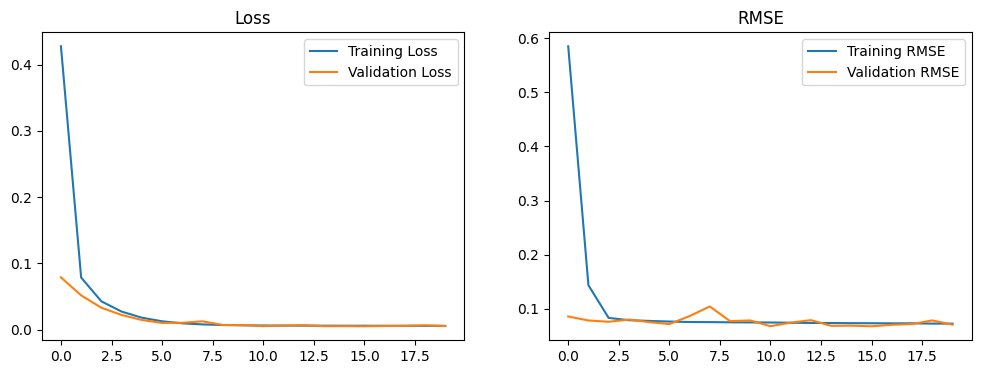

In [37]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['root_mean_squared_error'], label='Training RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE')
plt.title('RMSE')
plt.legend()
plt.show()


# Preparing test data and prediction

Scaling test features, creating sequences and making predictions on test data.


In [63]:

pred_pm25 = model.predict(X_test)

import numpy as np
import pandas as pd

sample_submission = pd.read_csv('/content/drive/MyDrive/Kaggle_competition_ML/air_quality_forcasting/sample_submission .csv')

full_preds = np.zeros(len(sample_submission))
time_steps = 24

# Filling predictions starting from time_steps index
full_preds[time_steps:] = pred_pm25.flatten()

sample_submission['pm2.5'] = full_preds
sample_submission.to_csv('submission.csv', index=False)

print("Submission file created with correct length and format.")


411/411 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step
Submission file created with correct length and format.
